# HK Stock Market Backtesting with RSI turns

List of HK stock from:
https://www.hkex.com.hk/eng/services/trading/securities/securitieslists/ListOfSecurities.xlsx

In [1]:
# -*- coding: utf-8 -*-
# import sys
# import csv
# import json
import os
import math
import traceback
import time
from typing import Dict
from datetime import datetime

import pandas as pd
import numpy as np
import talib as ta
from pandas_datareader import data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.dates import date2num, DayLocator, DateFormatter
# import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import yfinance as yf

# sys.path.append(os.path.abspath(os.path.pardir))

%matplotlib inline 
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [2]:
start = datetime(2014, 6, 1)  # First date of data
end = datetime(2021, 12, 1)  # Last date of data
# end = dt.datetime.now()  # Last date of data

In [3]:
def format_code(c: int) -> str:
    """
    Convert int code to string 
    """
    return f"{c:04d}.HK"

format_code(5)

'0005.HK'

In [4]:
# Load stock master data
df_stocks = pd.read_excel('ListOfSecurities.xlsx', skiprows=2)
df_stocks = df_stocks[df_stocks['Category'].isin(['Equity', 'Exchange Traded Products'])]
df_stocks['CODE'] = df_stocks['Stock Code'].apply(format_code)
df_stocks['Board Lot'] = df_stocks['Board Lot'].str.replace(',', '').astype(int)
df_stocks.set_index('CODE', inplace=True)
df_stocks.head()

Stock Code Name of Securities Category  \
CODE                                              
0001.HK           1       CKH HOLDINGS   Equity   
0002.HK           2       CLP HOLDINGS   Equity   
0003.HK           3     HK & CHINA GAS   Equity   
0004.HK           4     WHARF HOLDINGS   Equity   
0005.HK           5      HSBC HOLDINGS   Equity   

                           Sub-Category  Board Lot   Par Value          ISIN  \
CODE                                                                           
0001.HK  Equity Securities (Main Board)        500  HKD 1.0000  KYG217651051   
0002.HK  Equity Securities (Main Board)        500         NaN  HK0002007356   
0003.HK  Equity Securities (Main Board)       1000         NaN  HK0003000038   
0004.HK  Equity Securities (Main Board)       1000         NaN  HK0004000045   
0005.HK  Equity Securities (Main Board)        400  USD 0.5000  GB0005405286   

        Expiry Date Subject to Stamp Duty Shortsell Eligible CAS Eligible  \
CODE                                                                        
0001.HK         NaN                     Y                  Y            Y   
0002.HK         NaN                     Y                  Y            Y   
0003.HK         NaN                     Y                  Y            Y   
0004.HK         NaN                     Y                  Y            Y   
0005.HK         NaN                     Y                  Y            Y   

        VCM Eligible Admitted to Stock Options Admitted to Stock Futures  \
CODE                                                                       
0001.HK            Y                         Y                         Y   
0002.HK            Y                         Y                         Y   
0003.HK            Y                         Y                         Y   
0004.HK            Y                         Y                         Y   
0005.HK            Y                         Y                         Y   

        Admitted to CCASS ETF / Fund Manager  \
CODE                                           
0001.HK                 Y                NaN   
0002.HK                 Y                NaN   
0003.HK                 Y                NaN   
0004.HK                 Y                NaN   
0005.HK                 Y                NaN   

        Debt Securities Board Lot (Nominal) Debt Securities Investor Type  \
CODE                                                                        
0001.HK                                 NaN                           NaN   
0002.HK                                 NaN                           NaN   
0003.HK                                 NaN                           NaN   
0004.HK                                 NaN                           NaN   
0005.HK                                 NaN                           NaN   

        POS Eligble  Spread Table\n1, 4 = Part A\n3 = Part B\n5 = Part D  
CODE                                                                      
0001.HK           Y                                                  1    
0002.HK           Y                                                  1    
0003.HK           Y                                                  1    
0004.HK           Y                                                  1    
0005.HK           Y                                                  1

# Get daily stock price data

In [5]:
CACHE_FOLDER = 'yahoo'
CACHE_USE = True


def parse_cache_name(filename: str) -> Dict:
    """
    Parse a cache file name, into [stock_code, start_date, end_date, filename]
    """
    t = filename.replace('.csv', '').split('_')
    try:
        return t[0], datetime.strptime(t[1], "%Y%m%d"), datetime.strptime(t[2], "%Y%m%d"), filename
    except:
        return None, None, None, None 


def get_cached_price(code: str, 
                     start: datetime = datetime(2014, 1, 1), 
                     end: datetime = datetime.date(datetime.now()),
                     verbose: bool = True
                    ) -> pd.DataFrame:
    """
    Load data for a stock with date range, find in cache if available
    """
    
    # Find in cache
    caches = [parse_cache_name(f) for f in os.listdir(CACHE_FOLDER)]
    caches = list(filter(lambda f: f[0] == code and f[1] <= start and f[2] >= end, caches))
    
    if len(caches) > 0:
        # load cache
        df = pd.read_csv(CACHE_FOLDER + '/' + caches[0][3], header=[0])
        df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y-%m-%d'))
        df = df.set_index('Date')
        
        return df[(df.index >= start) & (df.index <= end)]
    else:
        if verbose:
            print('Downloading data for', code)
        
        t = yf.Ticker(code)
        df = t.history(period='max')
        
        if len(df) == 0:  # no data
            file_start = start
            file_end = end
        else:
            file_start = min(df.index.min(), start)
            file_end = min(df.index.max(), end)
        
        # save cache
        filename = '{}/{}_{}_{}.csv'.format(CACHE_FOLDER, code, 
                                            file_start.strftime("%Y%m%d"), file_end.strftime("%Y%m%d"))
        df.reset_index().to_csv(filename, index=False)
        
        return df[(df.index >= start) & (df.index <= end)]

get_cached_price('1310.HK', start, end)

Open      High       Low     Close     Volume  Dividends  \
Date                                                                       
2015-03-12  6.604717  6.692878  6.479823  6.612064  132110000        0.0   
2015-03-13  6.648798  6.913281  6.619411  6.869201   27007158        0.0   
2015-03-16  6.927976  7.265926  6.832468  7.199805   27187001        0.0   
2015-03-17  7.258578  7.280618  7.126337  7.214498   14493946        0.0   
2015-03-18  7.199804  7.243884  7.096949  7.207150    9746000        0.0   
...              ...       ...       ...       ...        ...        ...   
2021-11-25  9.900000  9.900000  9.840000  9.870000     570102        0.0   
2021-11-26  9.890000  9.980000  9.720000  9.920000    1690136        0.0   
2021-11-29  9.850000  9.950000  9.850000  9.940000     802253        0.0   
2021-11-30  9.950000  9.950000  9.700000  9.800000    2716100        0.0   
2021-12-01  9.810000  9.850000  9.680000  9.760000    1536309        0.0   

            Stock Splits  
Date                      
2015-03-12             0  
2015-03-13             0  
2015-03-16             0  
2015-03-17             0  
2015-03-18             0  
...                  ...  
2021-11-25             0  
2021-11-26             0  
2021-11-29             0  
2021-11-30             0  
2021-12-01             0  

[1660 rows x 7 columns]

# Backtesting and Visualization Functions

In [6]:
def plot_result(code: str, 
                df2: pd.DataFrame, 
                verbose: bool = True
               ) -> None:
    """
    Plot the backtest results
    """
    
    ############################ Visualization ############################
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(24, 10), dpi=300, sharex=True, 
                                        gridspec_kw={'hspace': 0, 'height_ratios': [2, 1, 2]})
    
    # Plots
    df2['dd_num'] = df2['dd'].apply(date2num)
    candlestick_ohlc(ax1, df2[["dd_num", "open", "high", "low", "close", "volume"]].values, \
                     width=0.4, colorup='#77d879', colordown='#db3f3f', alpha=0.75)
    
    x_ticks = df2['dd_num']
    
    # Stock price
    # ax1.plot(x_ticks, df2["sma10"], 'red', label='SMA-10', lw=1.0)
    # ax1.plot(x_ticks, df2["sma20"], 'yellow', label='SMA-20', lw=1.0)
    ax1.plot(x_ticks, df2["sma50"], 'green', label='SMA-50', lw=1.0)
    ax1.plot(x_ticks, df2["sma100"], 'teal', label='SMA-100', lw=1.0)
    ax1.plot(x_ticks, df2["sma250"], 'violet', label='SMA-250', lw=1.0)

    # RSI
    # ax2.plot(x_ticks, df2["rsi14"], 'orange', label='RSI-14', lw=1.0)
    ax2.plot(x_ticks, df2["rsi10"], 'green', label='RSI-10', lw=1.0)
    
    # Performance
    ax3.plot(x_ticks, df2["pocket_cash"], 'green', label='Pocket Cash', lw=1.0)
    ax3.plot(x_ticks, df2["NAV"], 'black', label='NAV', lw=1.0)
    # ax3.plot(x_ticks, df2["stock_bought"], 'orange', label='Stock Bought', lw=1.0)
    # ax2.plot(x_ticks, df2["MDD"], 'red', label='MDD', lw=1.0)

    # Actions
    ax3b = ax3.twinx()
    ax3b.plot(x_ticks, df2["MDD%"], 'red', label='MDD %', lw=1.0)
    ax3b.scatter(df2['dd_num'], df2['pause'].apply(lambda x: 0.5 if x else None), 
                 color='red', label='Force Sell', marker='x')
    
    # Axis
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('%b') 
    yearsFmt = mdates.DateFormatter('\n\n%Y')

    ax3.xaxis.set_minor_locator(months)
    ax3.xaxis.set_minor_formatter(monthsFmt)
    plt.setp(ax3.xaxis.get_minorticklabels(), rotation=90)
    ax3.xaxis.set_major_locator(years)
    ax3.xaxis.set_major_formatter(yearsFmt)
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=x_ticks[0])
    ax3b.set_ylim(0.0, 1.0)
    ax2.set_yticks(range(10, 101, 20))
    ax2.set_yticks(range(0, 101, 10), minor=True)
    
    # Grids
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax2.grid(which='both', axis='y')
    ax2.grid(which='major', axis='y', alpha=1.0)
    ax2.grid(which='minor', axis='y', alpha=0.2)
    ax1.grid(which='minor', axis='x', alpha=0.1)
    ax2.grid(which='minor', axis='x', alpha=0.1)
    ax3.grid(which='minor', axis='x', alpha=0.1)
    
    # Labels
    ax1.set_title(code)
    plt.xlabel('Date')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('RSI')
    ax3.set_ylabel('Money')
    ax3b.set_ylabel('MDD %')
    
    # Legends
    thousand_formatter = mticker.FuncFormatter(lambda x, p: format(int(x), ','))
    ax3.get_yaxis().set_major_formatter(thousand_formatter)
    lines_1, labels_1 = ax3.get_legend_handles_labels()
    lines_2, labels_2 = ax3b.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend()
    ax2.legend()
    ax3.legend(lines, labels, loc=0)

    if verbose:
        plt.show()
    
    fig.savefig(r"backtest/yahoo_stock_backtest.result.{}.png".format(code))
    plt.close()

------------------------------
Code 1310.HK, 1660 Days
Period:		6.72 Yr(s)
Stock Inc.:	+47.6%
Portfolio Inc.:	+36.6% (-11.0pp)
Stock AGR:	+5.96%
Portfolio AGR:	+4.75% (-1.2pp)
Max Draw Down:	$-404,630 (-25.0%)
Buy/Sell:	18 / 133
Force Action:	Buy 0 / 0, Sell 9 / 5


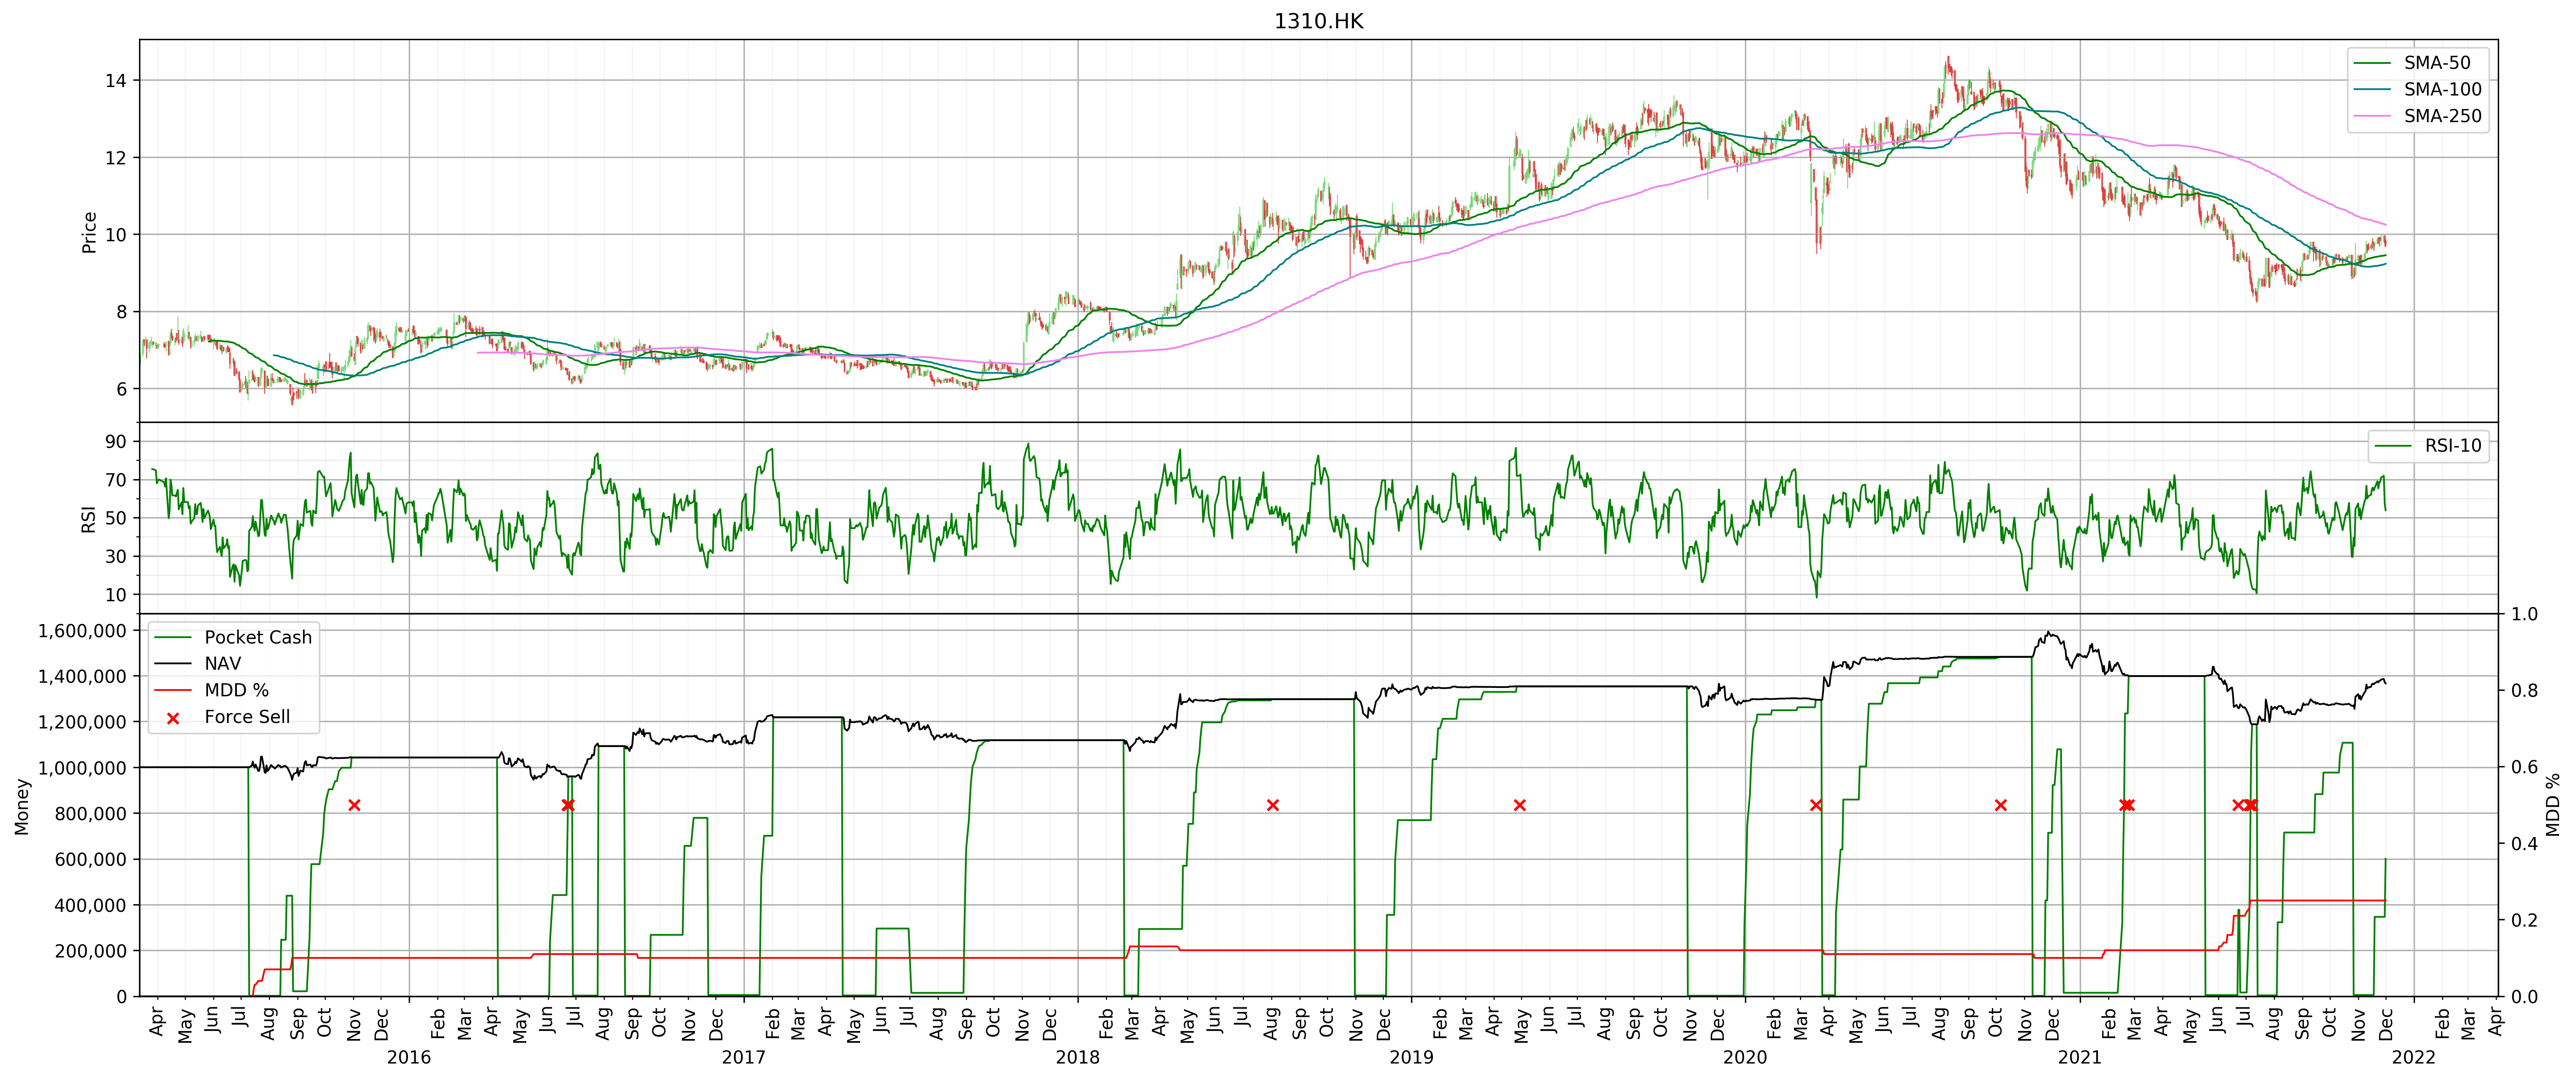

In [7]:
# %%time

def backtest_stock(code: str, 
                   inital_cash: float = 1_000_000, 
                   verbose: bool = True, 
                   plot_chart: bool = True
                  ) -> Dict:
    """
    Do backtesting
    Using RSI and SMA threshold
    """
    
    if verbose:
        print('-'*30)
    
    # Initialize
    lot_size = df_stocks.loc[code]['Board Lot']
    max_nav = pocket_cash = inital_cash
    started = False
    results = []
    
    # Get data
    df = get_cached_price(code, start, end, verbose=verbose)
    if verbose:
        print("Code {}, {} Days".format(code, len(df)))

    if len(df) <= 1:
        return False
    
    df = df.reset_index()
    new_columns = [str(c).lower().replace("date", "dd").replace(" ", "_") for c in df.columns]
    df.columns = new_columns

    ############################ Indicators ############################

    # df['sma10'] = ta.SMA(df['close'], timeperiod=10)
    # df['sma20'] = ta.SMA(df['close'], timeperiod=20)
    df['sma50'] = ta.SMA(df['close'], timeperiod=50)
    df['sma100'] = ta.SMA(df['close'], timeperiod=100)
    df['sma250'] = ta.SMA(df['close'], timeperiod=250)
    
    df['rsi10'] = ta.RSI(df['close'], timeperiod=10)
    df['rsi14'] = ta.RSI(df['close'], timeperiod=14)

    # df = df.dropna(axis=0) # drop early record without sma

    ############################ Preprocessing ############################
    
    for c in ['open', 'high', 'low', 'close', 'adj_close']:
        if c not in df.columns:
            df[c] = None
        else:
            df[c] = df[c].round(5)
    
    df['rsi10_slope'] = df['rsi10'].diff(periods=1)
    df['rsi14_slope'] = df['rsi14'].diff(periods=1)
    df['rsi10_slope2'] = df['rsi10'].diff(periods=3)
    df['rsi14_slope2'] = df['rsi14'].diff(periods=3)
    
    RSI_SLOPE = RSI + '_slope'
    RSI_SLOPE2 = RSI + '_slope2'
    TOTAL_LEVEL = 10
    
    
    def set_level(l: int, remarks: str = "") -> None:
        """
        Record - Set stock level to l
        """
        
        if remarks:
            r['remarks'] += "{}; ".format(remarks)
        
        r['tiggered'] = True
        r['stock_level'] = l
        r['stock_level'] = max(min(r['stock_level'], TOTAL_LEVEL), 0) # 0 >= stock_level >= TOTAL_LEVEL
    
    
    def inc_level(l: int, remarks: str = "") -> None:
        """
        Record - Increase (or decrase) stock level by l
        """
        
        if remarks:
            r['remarks'] += "{}; ".format(remarks)
        
        r['tiggered'] = True
        r['stock_level'] += l
        r['stock_level'] = max(min(r['stock_level'], TOTAL_LEVEL), 0) # 0 >= stock_level >= TOTAL_LEVEL
    
    ############################ Trade Logics ############################
    
    count_buy = 0
    count_sell = 0
    count_cut_loss = 0
    count_stop_loss = 0
    count_cut_profit = 0
    count_stop_profit = 0
    p1 = None # previous 1
    p2 = None # previous 2
    
    rows = df.to_dict("records")
    for r in rows:
        r['action'] = ""
        r['remarks'] = ""
        r['tiggered'] = False
        r['pause'] = False
        long_hold = False
        
        if p1 == None: # first row
            r['stock_level'] = 0
            r['stock_cost'] = 0
            r['stock_avg_cost'] = 0
            r['stock_bought'] = 0
            r['stock_margin'] = 0
            r['pause'] = False
            r['rsi_low'] = 0
            r['rsi_high'] = 0
            r['rsi_drop'] = 0
            r['quite_days'] = 0
            r['stock_margin_max'] = 0
            mdd = 0
        else:
            started = True
            r['stock_margin'] = 0 if p1['stock_avg_cost'] == None \
                                    else (r['close'] - p1['stock_avg_cost']) / p1['stock_avg_cost']
            r['stock_level'] = p1['stock_level']
            r['stock_bought'] = p1['stock_bought']
            r['stock_cost'] = p1['stock_cost']
            r['stock_avg_cost'] = p1['stock_avg_cost']
            r['rsi_low'] = p1['rsi_low']
            r['rsi_high'] = p1['rsi_high']
            r['rsi_drop'] = p1['rsi_drop']
            r['quite_days'] = p1['quite_days']
            r['stock_margin_max'] = max(r['stock_margin'], p1['stock_margin_max'])
        
        ######### RSI conditions ######### 
        if r[RSI] <= RSI_BOTTOM: r['rsi_low'] += 1
        else: r['rsi_low'] = 0
        if r[RSI] >= RSI_TOP: r['rsi_high'] += 1
        else: r['rsi_high'] = 0
        if r[RSI] >= RSI_DECENT and r[RSI_SLOPE] <= 1: r['rsi_drop'] += 1
        else: r['rsi_drop'] = 0
        
        if started:
            ######### Stock Level Update ######### 
            if r['stock_margin_max'] > STOP_PROFIT_TRIGGER and \
                r['stock_margin'] - r['stock_margin_max'] < STOP_PROFIT_THRESHOLD:
                set_level(0, "SAFTY THRESHOLD {:.2%} back {:.2%}".format(r['stock_margin'], 
                                                                         r['stock_margin'] - r['stock_margin_max']))
                count_stop_loss += 1
                r['stock_margin_max'] = 0
                r['pause'] = True
            elif r['stock_margin'] < STOP_LOSS_PERC:
                set_level(0, "STOP_LOSS {:.2%}".format(r['stock_margin']))
                count_stop_loss += 1
                r['pause'] = True
            elif r['stock_margin'] < CUT_LOSS_PERC:
                inc_level(-3, "CUT_LOSS {:.2%}".format(r['stock_margin']))
                count_cut_loss += 1
                r['pause'] = True
            elif r['stock_margin'] > STOP_PROFIT_PERC:
                set_level(0, "STOP_PROFIT {:.2%}".format(r['stock_margin']))
                count_stop_profit += 1
                r['pause'] = True
            elif r['stock_margin'] > CUT_PROFIT_PERC:
                inc_level(-2, "CUT_PROFIT {:.2%}".format(r['stock_margin']))
                count_cut_profit += 1
                r['pause'] = True
            
            if not r['pause']:
                if r[RSI] > RSI_BOTTOM and r[RSI] < RSI_TOP:  # middle
                    if p1['rsi_low'] >= RSI_LOW_DAYS and r['stock_level'] != 10:  # just raised
                        set_level(max(10, r['stock_level']), "RSI back up")
                    elif p1['rsi_high'] >= RSI_HIGH_DAYS:  # just dropped
                        set_level(0, 'RSI back down')
                    if p1['rsi_drop'] >= RSI_DECENT_DAYS:
                        inc_level(-r['stock_level'] / 4, 'RSI decent')
                if not r['tiggered'] and p1['quite_days'] > HOLD_DURATION:  # holding stock for too long
                    inc_level(-r['stock_level'] / 4, 'Long Hold')
                    long_hold = True
            else:
                r['quite_days'] = 0
            
            ######### Order Execution #########
            total_lots = math.floor(p1['NAV'] / lot_size / r['close'])
            expected_lots = math.floor(r['stock_level'] / TOTAL_LEVEL * total_lots)
            expected_bought = expected_lots * lot_size
            stock_diff = expected_bought - r['stock_bought']
            
            if r['tiggered']:
                if stock_diff > 0 and (r['close'] > r['sma250'] or not ABOVE_SMA_ONLY):  # Buy
                    pocket_cash -= stock_diff * r['close']
                    r['stock_bought'] += stock_diff
                    r['action'] = "buy {}".format(stock_diff)
                    r['stock_cost'] += stock_diff * r['close']
                    count_buy += 1
                elif stock_diff < 0: # Sell
                    pocket_cash -= stock_diff * r['close']
                    r['stock_bought'] += stock_diff
                    r['action'] = "sell {}".format(stock_diff)
                    r['stock_cost'] = r['stock_avg_cost'] * r['stock_bought']  # keep avg cost unchanged
                    count_sell += 1
                if not long_hold:
                    r['quite_days'] = 0
                else:
                    r['quite_days'] += 1
            else:
                if r['stock_bought'] > 0: r['quite_days'] += 1
        
        ######### Update Result #########
        r['pocket_cash'] = pocket_cash
        r['stock_avg_cost'] = None if r['stock_bought'] == 0 else round(r['stock_cost'] / r['stock_bought'], 2)
        r['NAV'] = pocket_cash + r['stock_bought'] * r['close']
        r['stock_%'] = round((r['stock_bought'] * r['close']) / r['NAV'] * 100, 2)
        
        max_nav = max(max_nav, r['NAV'])
        mdd = max(mdd, max_nav - r['NAV'])
        mdd_perc = round(mdd / max_nav, 2)
        r['MDD'] = mdd
        r['MDD%'] = mdd_perc
        
        p2 = p1
        p1 = r

    ############################ Results ############################
    
    # results
    df2 = pd.DataFrame.from_dict(rows)
    
    # save for record
    df2.to_csv(r"backtest/yahoo_stock_backtest.result.{}.csv".format(code))
    
    stock_inc_perc = (df2['close'].iloc[-1] - df2['close'].iloc[0]) / df2['close'].iloc[0]
    portfolio_inc_perc = (df2['NAV'].iloc[-1] - df2['NAV'].iloc[0]) / df2['NAV'].iloc[0]
    T = (df2['dd'].iloc[-1] - df2['dd'].iloc[0]).days / 365.25 # years
    portfolio_agr = math.exp(math.log(df2['NAV'].iloc[-1] / df2['NAV'].iloc[0]) / T) - 1 # annual growth rate
    stock_agr = math.exp(math.log(df2['close'].iloc[-1] / df2['close'].iloc[0]) / T) - 1 # annual growth rate
    
    if verbose:
        print('Period:\t\t{:.2f} Yr(s)'.format(T))
        print('Stock Inc.:\t{:+.1%}'.format(stock_inc_perc))
        print('Portfolio Inc.:\t{:+.1%} ({:+.1f}pp)'.format(portfolio_inc_perc, \
                                                            (portfolio_inc_perc - stock_inc_perc) * 100))
        print('Stock AGR:\t{:+.2%}'.format(stock_agr))
        print('Portfolio AGR:\t{:+.2%} ({:+.1f}pp)'.format(portfolio_agr, \
                                                            (portfolio_agr - stock_agr) * 100))
        print('Max Draw Down:\t${:,.0f} ({:.1%})'.format(-mdd, -mdd_perc))
        print('Buy/Sell:\t{:,} / {:,}'.format(count_buy, count_sell))
        print('Force Action:\tBuy {} / {}, Sell {} / {}'.format(count_cut_profit, count_stop_profit, \
                                                                count_cut_loss, count_stop_loss))
    
    if plot_chart:
        plot_result(code, df2, verbose)
    
    return {
        "code": code,
        "init_volume": round((df2['volume'] * df2['close'])[:30].mean() / 1e6, 2),  # first 30 days avg. trade volume
        "NAV": round(df2['NAV'].iloc[-1], 2),  # Net Asset Value
        "stock_inc_perc": round(stock_inc_perc, 5),
        "portfolio_inc_perc": round(portfolio_inc_perc, 5),
        "outperform_pp": round(portfolio_inc_perc - stock_inc_perc, 5),
        "portfolio_agr": round(portfolio_agr, 5),
        "stock_agr": round(stock_agr, 5),
        "MDD": round(mdd, 2),  # Maximum Drawdown
        "MDD_prec": round(mdd_perc, 5),
        "count_buy": count_buy,
        "count_sell": count_sell,
        "days": len(df),
        "period": round(T, 3),  # years
        "df_result": df2
    }


############################ Strategy Settings ############################
RSI = 'rsi10'  # RSI to use
CUT_LOSS_PERC = -0.10  # reduce stock holding when loss margin reached
STOP_LOSS_PERC = -0.15  # clear stock holding when loss margin reached
CUT_PROFIT_PERC = 99.9  # reduce stock holding when profit margin reached
STOP_PROFIT_PERC = 99.9  # clear stock holding when profit margin reached
STOP_PROFIT_TRIGGER = 0.15  # trigger margin for Trailing stops
STOP_PROFIT_THRESHOLD = -0.15  # Trailing stops droping margin

RSI_LOW_DAYS = 2  # days to wait sell action
RSI_HIGH_DAYS = 2  # days to wait buy action  
RSI_DECENT_DAYS = 2  # days to wait sell action on lower RSI
HOLD_DURATION = 40  # reducing holding after days of no action
ABOVE_SMA_ONLY = False  # buy only when above SMA 200 line

RSI_TOP = 80  # RSI top trigger line
RSI_DECENT = 50  # RSI middle trigger line
RSI_BOTTOM = 30  # RSI bottom trigger line

# result = backtest_stock('0002.HK', verbose=True, plot_chart=False)
# result = backtest_stock('0005.HK', verbose=True, plot_chart=False)
# result = backtest_stock('0011.HK', verbose=True, plot_chart=True)
result = backtest_stock('1310.HK', verbose=True, plot_chart=True)

In [8]:
# Trade Actions for debugging
print("Trade Actions for debugging")
df3 = result['df_result'][['dd', 'close', 'rsi10', 'action', 'remarks', 'stock_level', 'rsi_drop', 'quite_days',
                           'stock_avg_cost', 'stock_bought', 'stock_margin', 'stock_margin_max', 'NAV']]
df3[df3['action'] != '']

Trade Actions for debugging


dd    close      rsi10       action        remarks  stock_level  \
80   2015-07-10  6.20065  42.972863   buy 161000  RSI back up;     10.000000   
105  2015-08-14  6.19330  47.313976  sell -39500   RSI decent;      7.500000   
109  2015-08-20  6.20800  47.782800  sell -31000   RSI decent;      5.625000   
114  2015-08-27  5.79658  35.127465    buy 72000  RSI back up;     10.000000   
125  2015-09-14  6.09045  53.428314  sell -38500   RSI decent;      7.500000   
...         ...      ...        ...          ...            ...          ...   
1625 2021-10-12  9.35000  50.382136   sell -8000   RSI decent;      1.779785   
1626 2021-10-15  9.25000  43.449121   sell -6000   RSI decent;      1.334839   
1634 2021-10-27  9.07000  39.543959   buy 121500  RSI back up;     10.000000   
1651 2021-11-19  9.76000  65.516751  sell -35000   RSI decent;      7.500000   
1659 2021-12-01  9.76000  53.882222  sell -26000   RSI decent;      5.625000   

      rsi_drop  quite_days  stock_avg_cost  stock_bought  stock_margin  \
80           0           0            6.20        161000      0.000000   
105          0           0            6.20        121500     -0.001081   
109          0           0            6.20         90500      0.001290   
114          0           0            6.02        162500     -0.065068   
125          3           0            6.02        124000      0.011703   
...        ...         ...             ...           ...           ...   
1625         3           0            8.58         24000      0.089744   
1626         0           0            8.58         18000      0.078089   
1634         0           0            9.01        139500      0.057110   
1651         0           0            9.01        104500      0.083241   
1659         3           0            9.01         78500      0.083241   

      stock_margin_max          NAV  
80            0.000000  1000000.000  
105           0.046318   998816.650  
109           0.046318  1000602.700  
114           0.046318   963369.190  
125           0.046318  1011123.065  
...                ...          ...  
1625          0.139860  1275861.560  
1626          0.139860  1273461.560  
1634          0.139860  1270221.560  
1651          0.139860  1366476.560  
1659          0.139860  1366476.560  

[151 rows x 13 columns]

------------------------------
Code 0001.HK, 1853 Days
Period:		7.50 Yr(s)
Stock Inc.:	-35.4%
Portfolio Inc.:	+43.4% (+78.9pp)
Stock AGR:	-5.67%
Portfolio AGR:	+4.93% (+10.6pp)
Max Draw Down:	$-229,397 (-16.0%)
Buy/Sell:	22 / 147
Force Action:	Buy 0 / 0, Sell 7 / 5


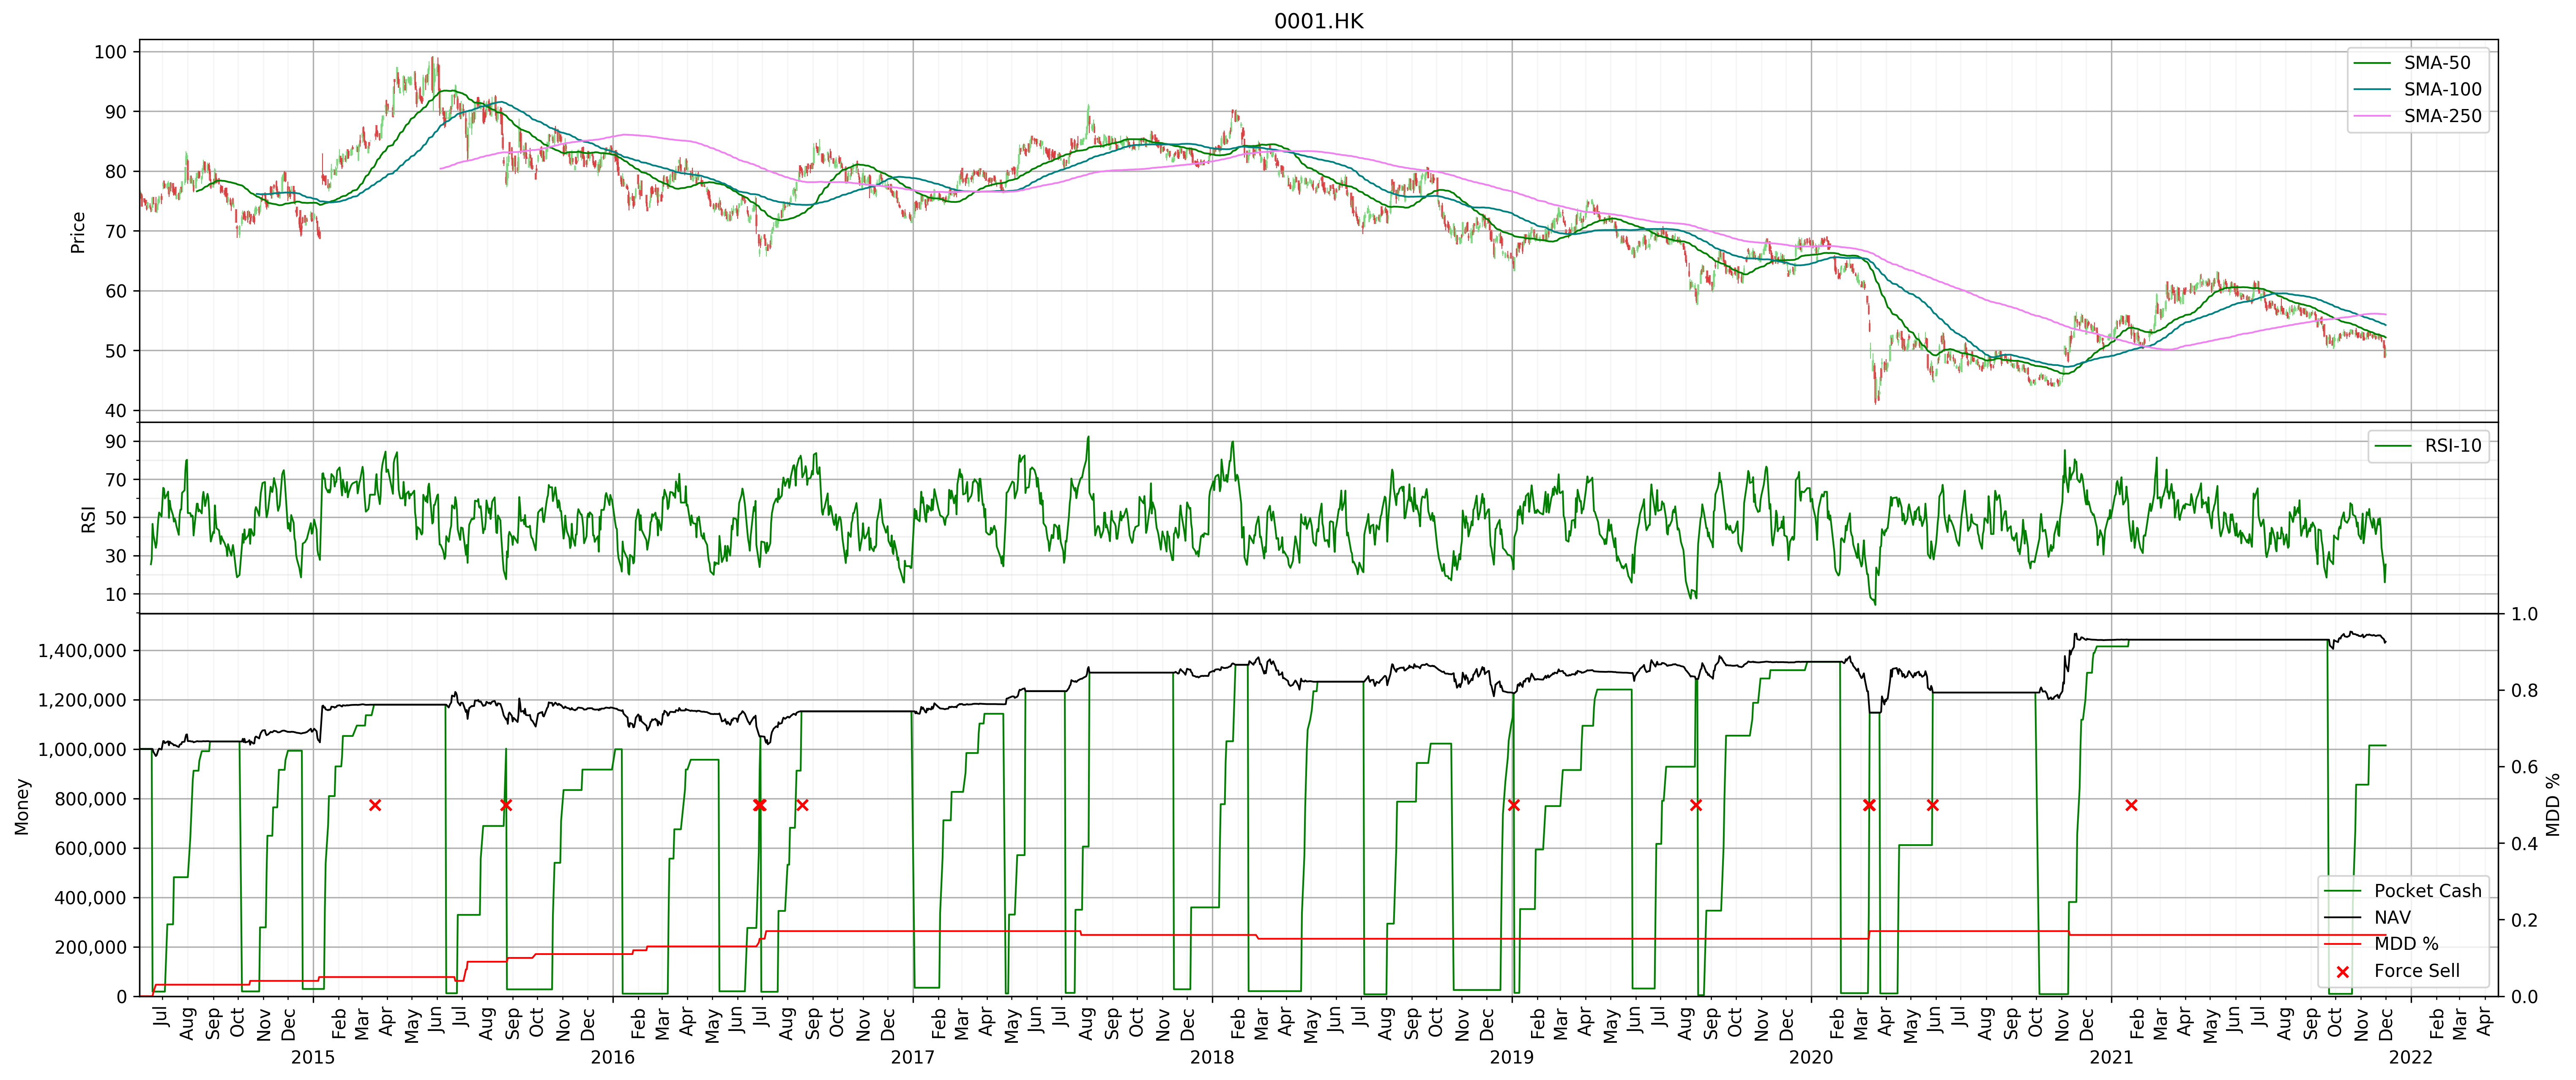

------------------------------
Code 0002.HK, 1853 Days
Period:		7.50 Yr(s)
Stock Inc.:	+60.3%
Portfolio Inc.:	+37.6% (-22.7pp)
Stock AGR:	+6.50%
Portfolio AGR:	+4.35% (-2.1pp)
Max Draw Down:	$-160,593 (-12.0%)
Buy/Sell:	10 / 94
Force Action:	Buy 0 / 0, Sell 1 / 2


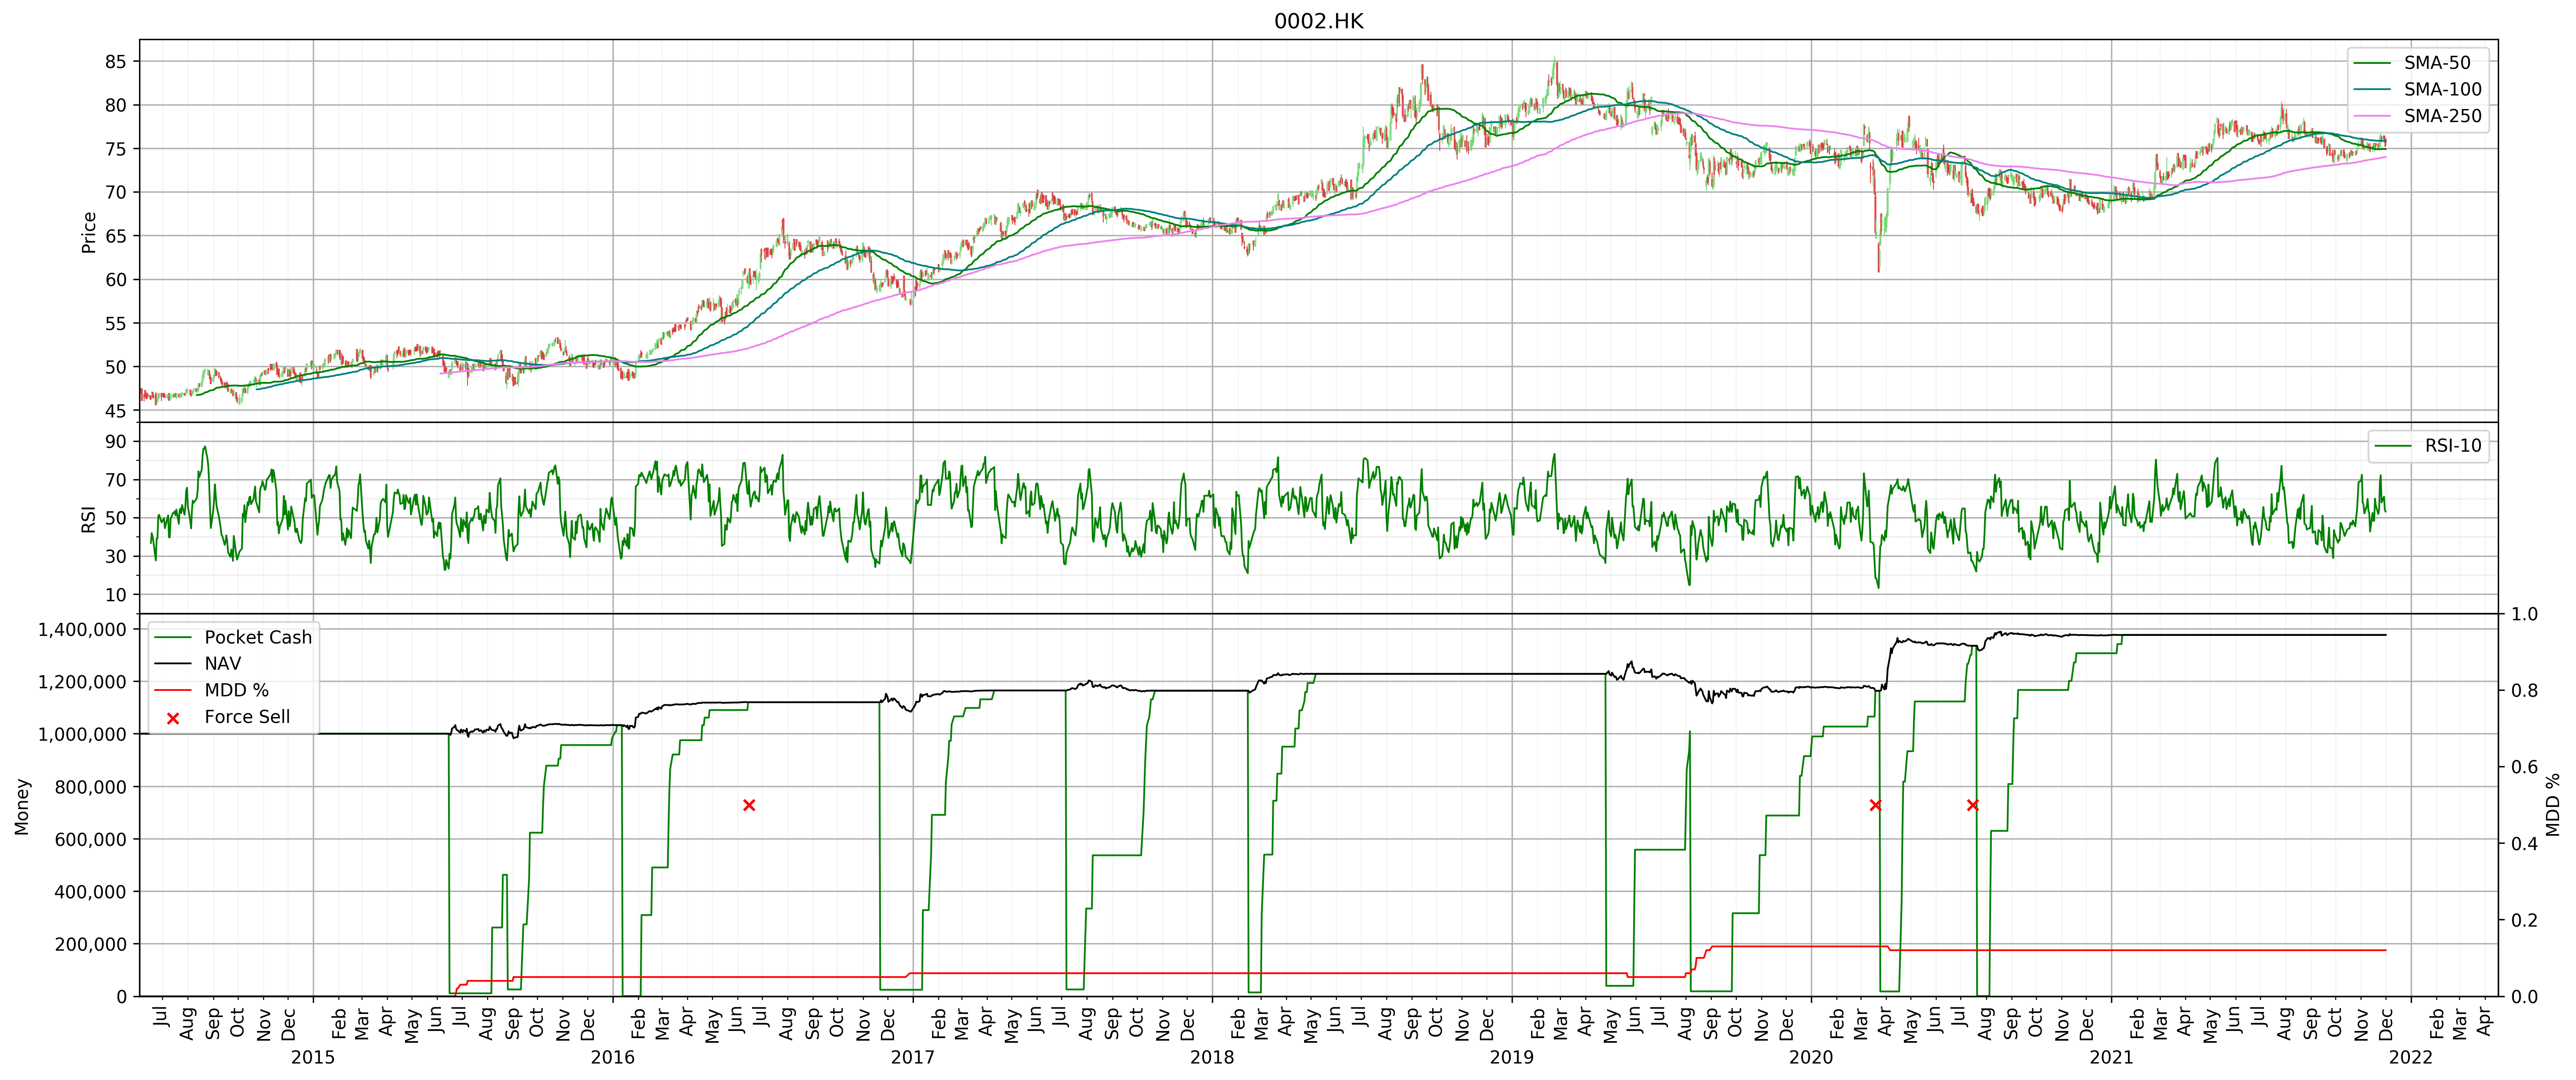

------------------------------
Code 0005.HK, 1853 Days
Period:		7.50 Yr(s)
Stock Inc.:	-22.9%
Portfolio Inc.:	-36.4% (-13.5pp)
Stock AGR:	-3.42%
Portfolio AGR:	-5.86% (-2.4pp)
Max Draw Down:	$-521,204 (-50.0%)
Buy/Sell:	25 / 116
Force Action:	Buy 0 / 0, Sell 18 / 5


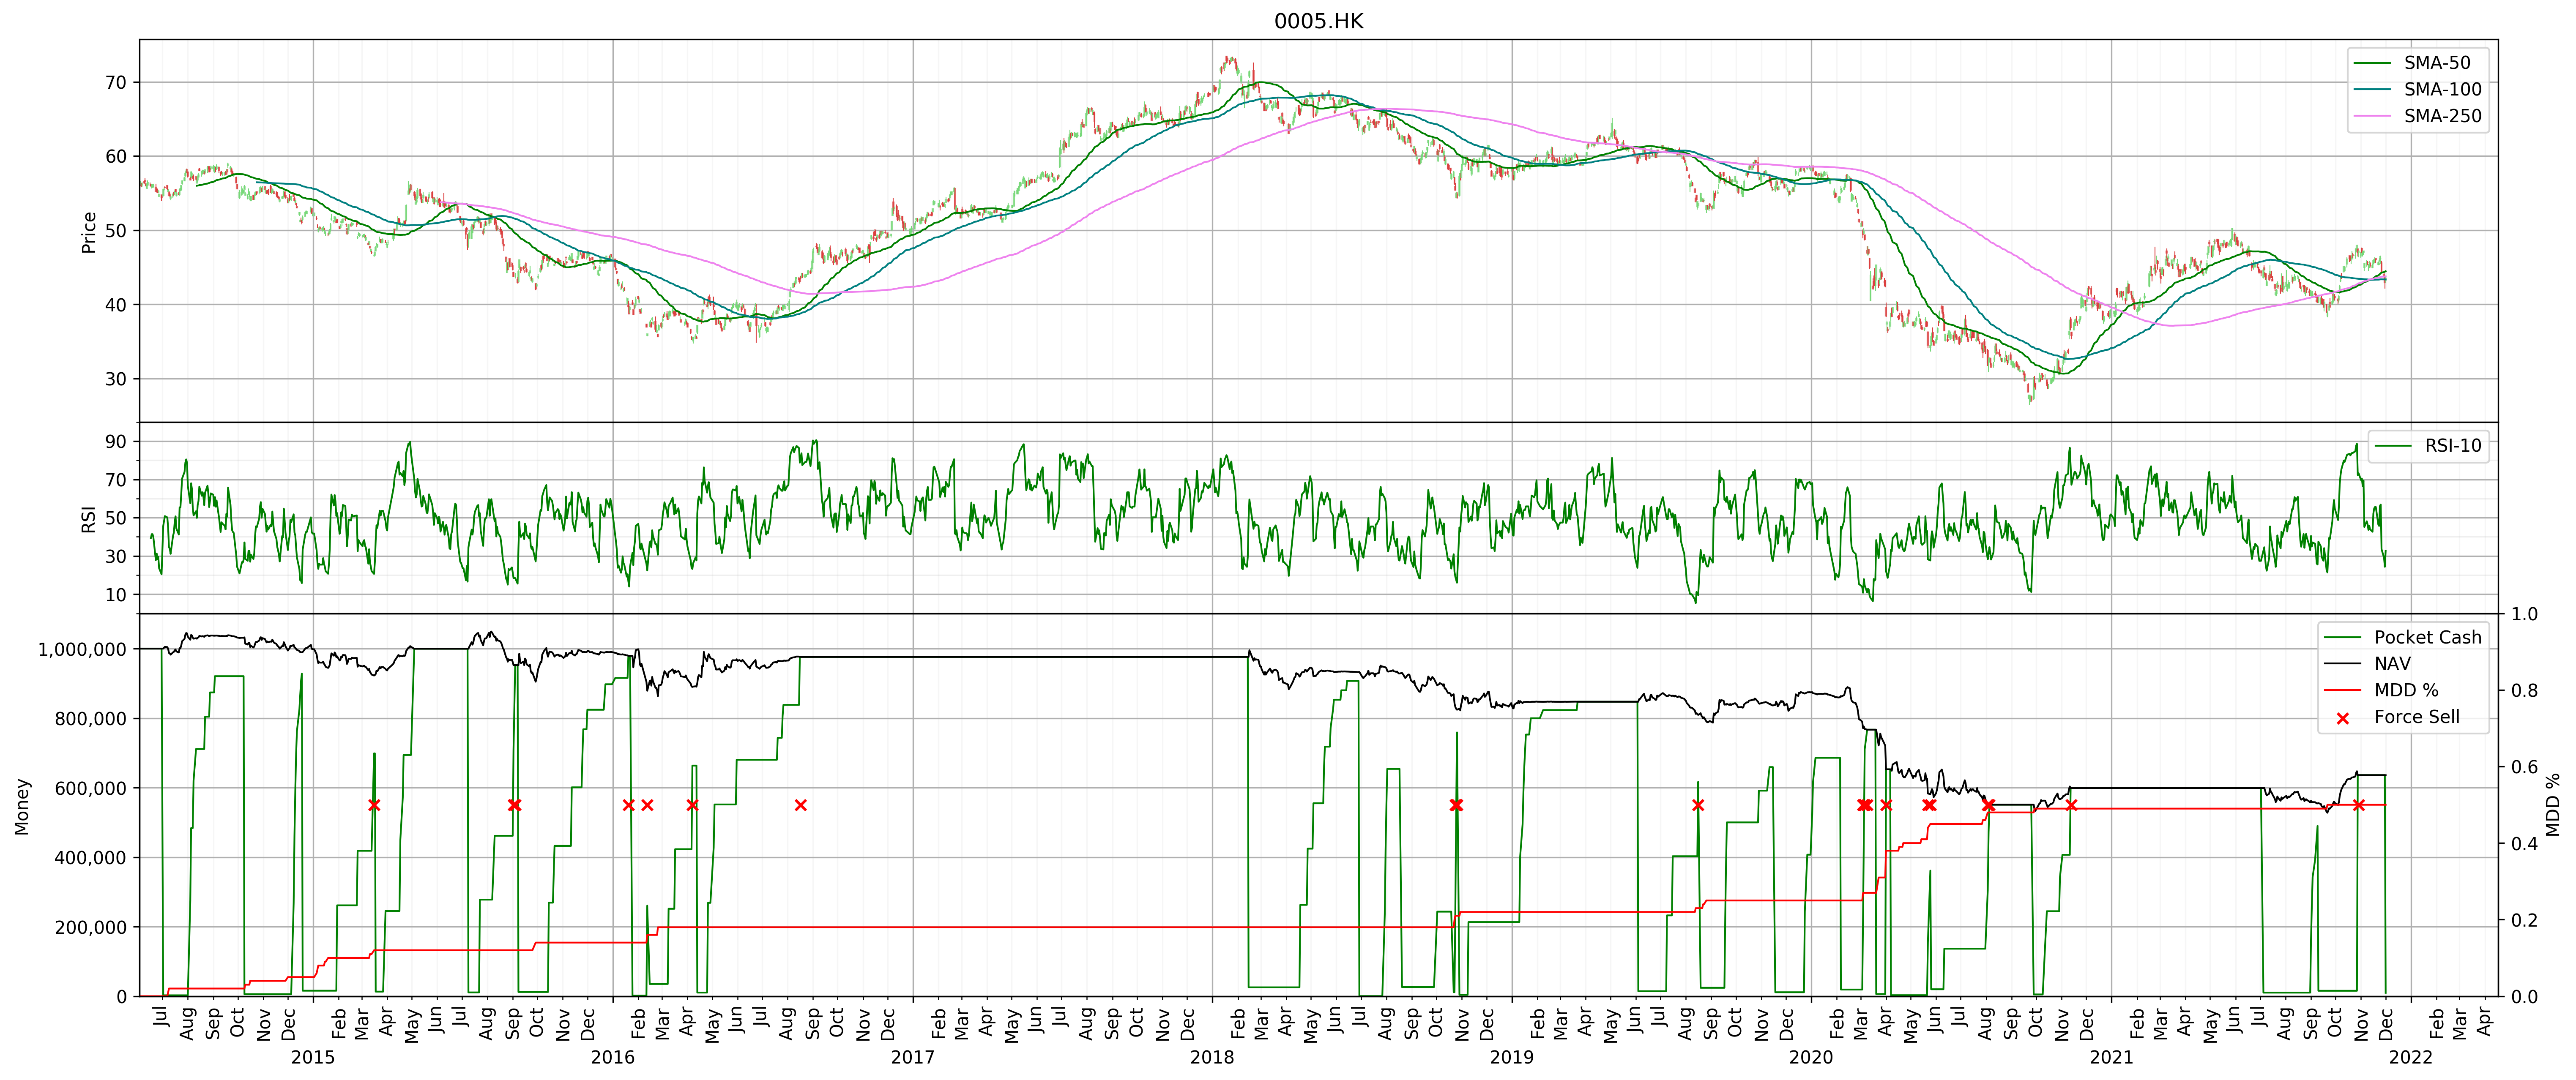

------------------------------
Code 0941.HK, 1853 Days
Period:		7.50 Yr(s)
Stock Inc.:	-14.7%
Portfolio Inc.:	+22.0% (+36.8pp)
Stock AGR:	-2.11%
Portfolio AGR:	+2.69% (+4.8pp)
Max Draw Down:	$-314,116 (-23.0%)
Buy/Sell:	21 / 123
Force Action:	Buy 0 / 0, Sell 3 / 5


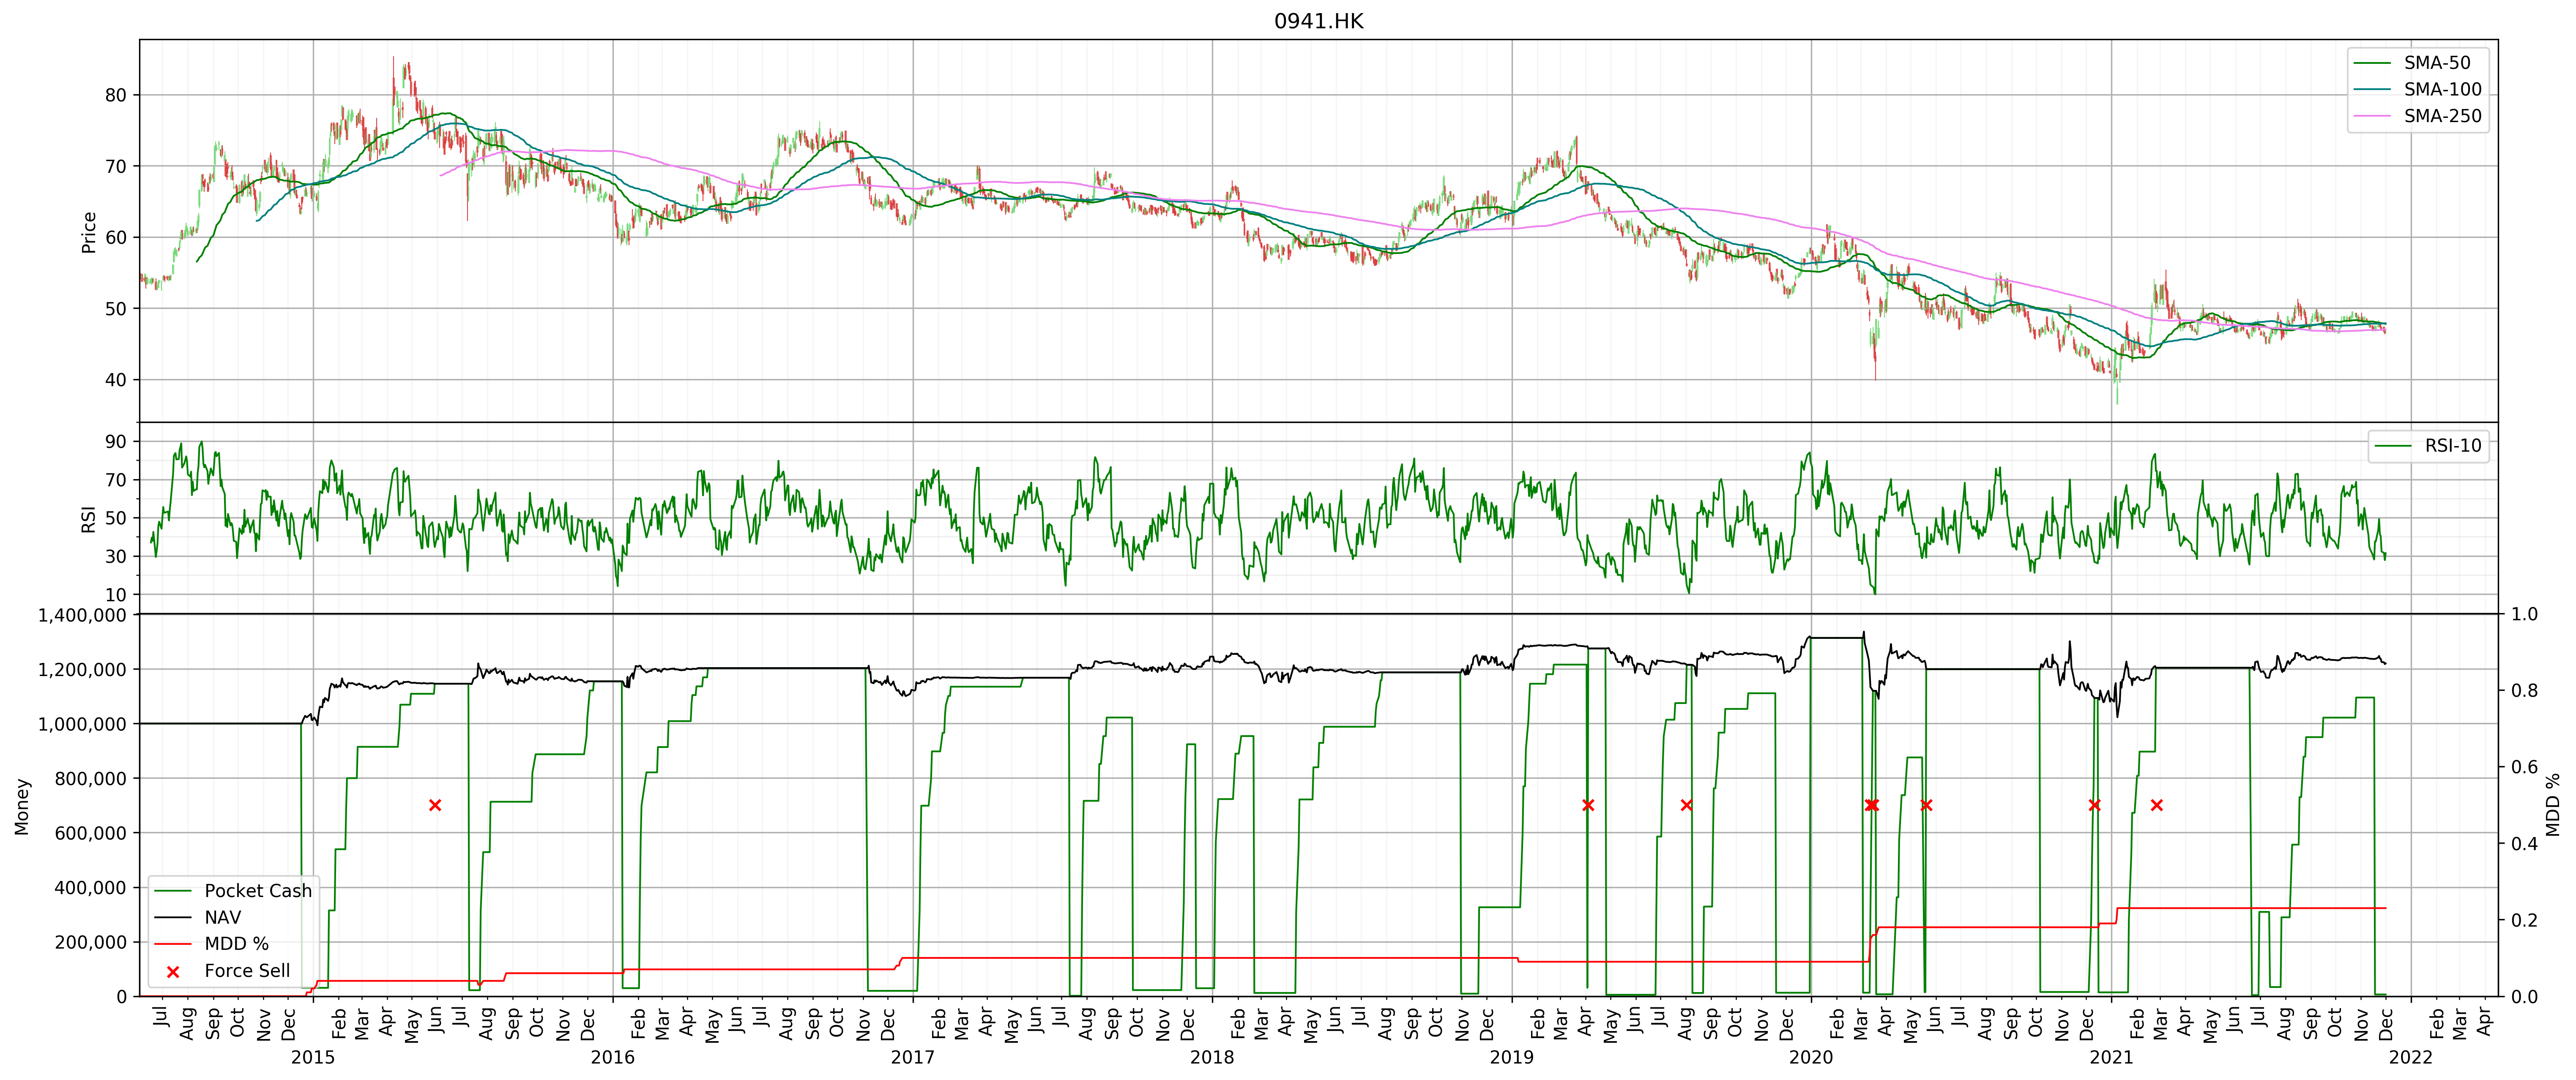

------------------------------
Code 0992.HK, 1853 Days
Period:		7.50 Yr(s)
Stock Inc.:	+18.6%
Portfolio Inc.:	-9.9% (-28.5pp)
Stock AGR:	+2.30%
Portfolio AGR:	-1.38% (-3.7pp)
Max Draw Down:	$-547,536 (-49.0%)
Buy/Sell:	25 / 147
Force Action:	Buy 0 / 0, Sell 24 / 11


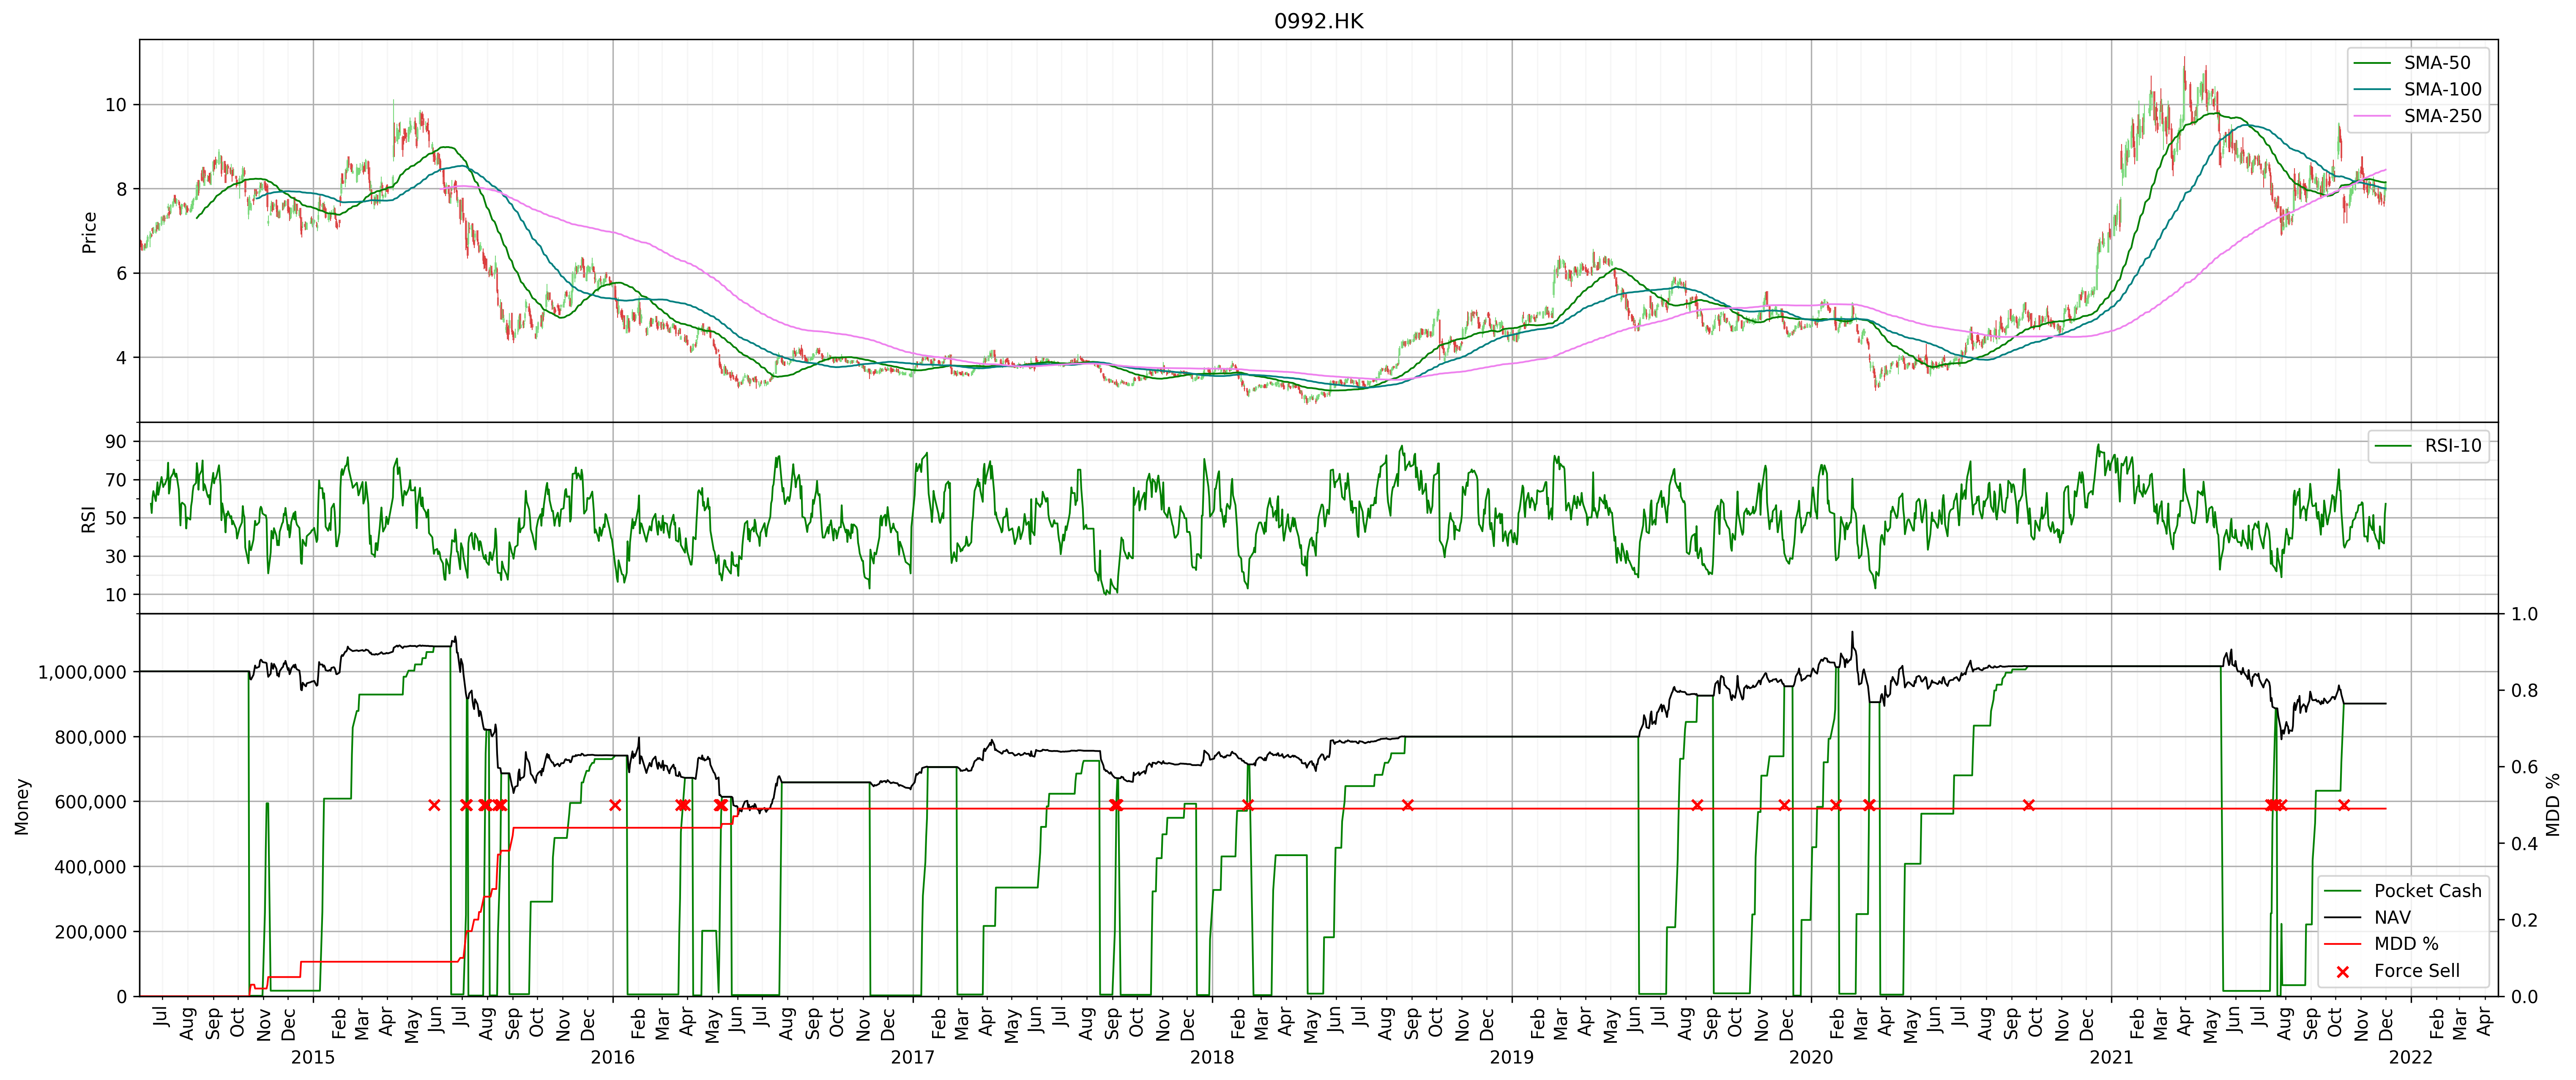

In [9]:
for s1 in ['0001.HK', '0002.HK', '0005.HK', '0941.HK', '0992.HK']:
    backtest_stock(s1, verbose=True, plot_chart=True)

# Backtesting on all stocks

In [10]:
all_stocks = df_stocks.index.tolist()
print(len(all_stocks))

2836


In [11]:
%%time

results = []
tic = time.time()
# for s1 in top_stocks[:20]:
for code in all_stocks:
    try:
        t = backtest_stock(code, verbose=False, plot_chart=False)
        if t != False:
            results.append(t)
    except KeyboardInterrupt:
        raise
    except:
        pass
    
    # status
    toc = time.time()
    if toc - tic > 60:
        print('{}/{}, {:.2%}'.format(len(results), len(all_stocks), len(results) / len(all_stocks)))
        tic = toc

df_r = pd.DataFrame(results)
df_r.to_csv('backtest_result.csv')
df_r

75/2836, 2.64%
153/2836, 5.39%
231/2836, 8.15%
311/2836, 10.97%
396/2836, 13.96%
481/2836, 16.96%
563/2836, 19.85%
646/2836, 22.78%
736/2836, 25.95%
826/2836, 29.13%
911/2836, 32.12%
1004/2836, 35.40%
1138/2836, 40.13%
1316/2836, 46.40%
1510/2836, 53.24%
1713/2836, 60.40%
1827/2836, 64.42%
1983/2836, 69.92%
2117/2836, 74.65%
2297/2836, 80.99%
2401/2836, 84.66%
2537/2836, 89.46%
CPU times: user 22min 35s, sys: 9.04 s, total: 22min 44s
Wall time: 23min 50s


code  init_volumne         NAV  stock_inc_perc  portfolio_inc_perc  \
0      0001.HK        299.21  1434210.56        -0.35450             0.43421   
1      0002.HK         96.43  1376206.47         0.60282             0.37621   
2      0003.HK        105.83  1103036.13         0.43496             0.10304   
3      0004.HK        154.14   736429.16         1.67526            -0.26357   
4      0005.HK        587.55   635998.79        -0.22947            -0.36400   
...        ...           ...         ...             ...                 ...   
2768  83168.HK          0.03  1254851.43         0.22541             0.25485   
2769  83186.HK          0.03   604670.00         4.95399            -0.39533   
2770  83188.HK          8.45   846308.00         1.25629            -0.15369   
2771  83197.HK          0.16  1290728.00         0.20690             0.29073   
2772  83199.HK          2.23   969283.00        -0.02270            -0.03072   

      outperform_pp  portfolio_agr  stock_agr        MDD  MDD_prec  count_buy  \
0           0.78871        0.04928   -0.05672  229396.78      0.16         22   
1          -0.22662        0.04352    0.06496  160593.00      0.12         10   
2          -0.33193        0.01317    0.04936  176348.37      0.15         16   
3          -1.93883       -0.03999    0.14028  543546.75      0.48         21   
4          -0.13453       -0.05859   -0.03418  521204.16      0.50         25   
...             ...            ...        ...        ...       ...        ...   
2768        0.02944        0.03075    0.02749  131160.00      0.10         25   
2769       -5.34932       -0.13691    0.68563  479282.50      0.46         14   
2770       -1.40998       -0.02201    0.11466  393030.00      0.39         18   
2771        0.08383        0.06921    0.05054  107318.00      0.08         16   
2772       -0.00802       -0.00415   -0.00306   97417.00      0.09         18   

      count_sell  days  period  \
0            147  1853   7.496   
1             94  1853   7.496   
2             89  1853   7.496   
3            116  1853   7.496   
4            116  1853   7.496   
...          ...   ...     ...   
2768         190  1853   7.496   
2769          52   845   3.417   
2770         133  1853   7.496   
2771         117   940   3.814   
2772         202  1853   7.496   

                                              df_result  
0                  dd      open      high       low ...  
1                  dd      open      high       low ...  
2                  dd      open      high       low ...  
3                  dd      open      high       low ...  
4                  dd      open      high       low ...  
...                                                 ...  
2768               dd   open   high    low  close  v...  
2769              dd     open     high      low    c...  
2770               dd   open   high    low  close  v...  
2771              dd   open   high    low  close  vo...  
2772               dd    open    high     low   clos...  

[2773 rows x 15 columns]

In [12]:
# Results Stats
df_r[df_r['init_volume'] > 1.0].describe()

init_volumne           NAV  stock_inc_perc  portfolio_inc_perc  \
count   1925.000000  1.925000e+03     1925.000000         1925.000000   
mean      52.873829  9.692731e+05        0.130123           -0.030727   
std      214.453483  6.250619e+05        2.064540            0.625062   
min        1.020000  7.325000e+03       -0.999830           -0.992680   
25%        4.020000  6.147650e+05       -0.724300           -0.385230   
50%        9.150000  8.990723e+05       -0.338910           -0.100930   
75%       28.180000  1.178900e+06        0.196970            0.178900   
max     5382.370000  1.087222e+07       40.346150            9.872220   

       outperform_pp  portfolio_agr    stock_agr           MDD     MDD_prec  \
count    1925.000000    1925.000000  1925.000000  1.925000e+03  1925.000000   
mean       -0.160849      -0.032090    -0.082672  6.360522e+05     0.439584   
std         1.996020       0.149542     0.399652  4.469913e+05     0.221799   
min       -40.335260      -0.972430    -0.999120  0.000000e+00     0.000000   
25%        -0.213950      -0.097760    -0.258300  3.630358e+05     0.270000   
50%         0.169850      -0.021890    -0.094570  5.404768e+05     0.420000   
75%         0.484260       0.034210     0.037500  8.094800e+05     0.610000   
max         9.547600       2.078050     7.485520  4.797625e+06     1.000000   

         count_buy   count_sell         days       period  
count  1925.000000  1925.000000  1925.000000  1925.000000  
mean     16.198442    84.259740  1319.939740     5.341111  
std       8.627309    47.586829   598.091665     2.420855  
min       0.000000     0.000000    14.000000     0.052000  
25%       9.000000    44.000000   833.000000     3.370000  
50%      17.000000    90.000000  1595.000000     6.456000  
75%      23.000000   121.000000  1853.000000     7.496000  
max      39.000000   232.000000  1888.000000     7.499000

1894
W. Portfolio	-2.64%
2800.HK		+0.80%


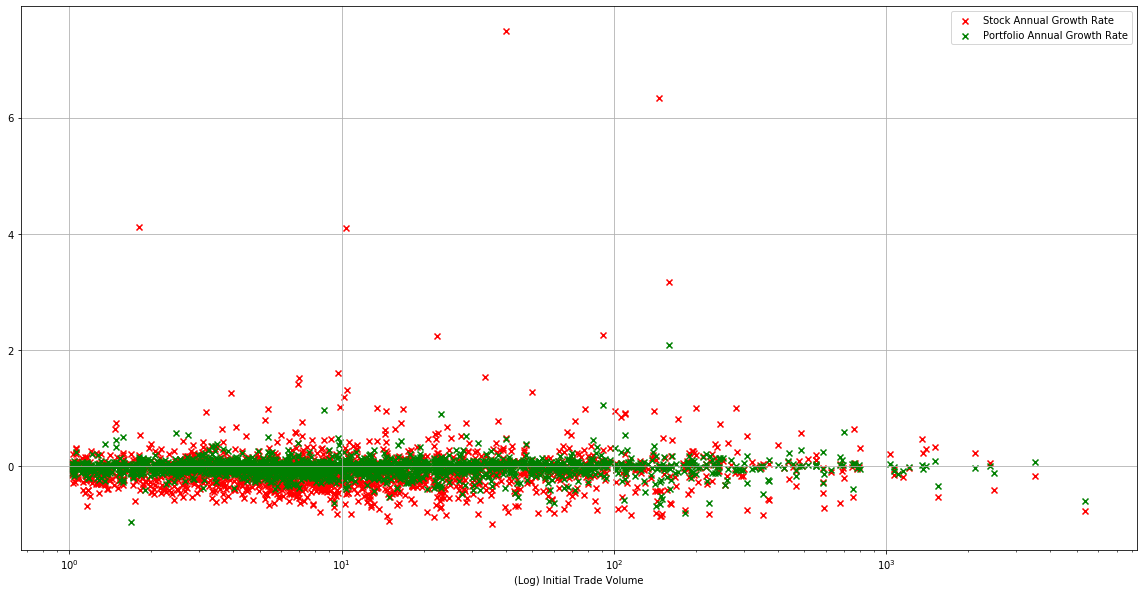

In [22]:
# Plot indivdual stock performance
df_r2 = df_r[df_r['init_volume'] > 1.0]
print(((df_r2['count_buy'] > 0) & (df_r2['count_sell'] > 0)).astype(int).sum())
print('W. Portfolio\t{:+.2%}'.format((df_r2['NAV'] * df_r2['init_volume']).sum() / df_r2['init_volume'].sum() / 1e6 - 1))
print('2800.HK\t\t{:+.2%}'.format(df_r[df_r['code']=='2800.HK'].stock_inc_perc.values[0]))
plt.figure(figsize=(20,10))
plt.scatter(df_r2['init_volume'], df_r2['stock_agr'], 
            marker='x', color='red', label='Stock Annual Growth Rate')
plt.scatter(df_r2['init_volume'], df_r2['portfolio_agr'], 
            marker='x', color='green', label='Portfolio Annual Growth Rate')
plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xlabel('(Log) Initial Trade Volume')
plt.show()